In [1]:

# Numbers
import numpy as np
import pandas as pd

# Serialization
import pickle

# Neural networks
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.python.client import device_lib

# Plotting
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from mouse_challenge_utils import *
from model import *

%matplotlib inline
sns.set(color_codes=True)

Using TensorFlow backend.


In [2]:

training_sessions, validation_sessions, testing_sessions = load_mouse_dynamics_dataset()

def print_stats(sessions, name):
    average_size = np.average([len(i['data']) for i in sessions])
    print('[*] Loaded {} {} sessions with an average of {:.2f} data points'.format(
        len(sessions), name, average_size))
    user_ids = [i['user_id'] for i in sessions]
    print('{} sessions per user: {}'.format(name, dict(Counter(user_ids))))
    
print_stats(training_sessions, 'training')
print_stats(validation_sessions, 'validation')
print_stats(testing_sessions, 'testing')
print()
print('[?] User 0 represents malicious user activity while User -1 represents an unknown user (unlabeled data)')

[*] Loaded 65 training sessions with an average of 31269.46 data points
training sessions per user: {35: 5, 7: 7, 9: 7, 12: 7, 15: 6, 16: 6, 20: 7, 21: 7, 23: 6, 29: 7}
[*] Loaded 411 validation sessions with an average of 1586.27 data points
validation sessions per user: {35: 35, 7: 36, 9: 23, 12: 56, 15: 45, 16: 68, 20: 30, 21: 37, 23: 38, 29: 43}
[*] Loaded 795 testing sessions with an average of 1358.64 data points
testing sessions per user: {-1: 795}

[?] User 0 represents malicious user activity while User -1 represents an unknown user (unlabeled data)


Convert training sessions to labeled examples, each example will have a seq_size sequence size, we will include three features per data point, the timestamp, the x position and the y position. We will one-hot encode the labels, and shuffle all the data.

In [3]:
df_train = sessions_to_dataframe(training_sessions)
df_val = sessions_to_dataframe(validation_sessions)
df_train.head()

,record_dt,client_dt,button,state,x,y,user_id
0,0.000,0.000,NoButton,Move,105,252,20
1,0.000,0.016,NoButton,Move,105,253,20
2,0.109,0.015,NoButton,Move,107,256,20
3,0.000,0.016,NoButton,Move,110,261,20
4,0.000,0.031,NoButton,Move,111,268,20


In [4]:
df_train = preprocess_data(df_train)
df_val = preprocess_data(df_val)
#### SPECIAL CASE #####
# There isnt any XButton data in the validation set so we better drop this column for the training set
# if we want to have the same number of features in both sets
df_train = df_train.drop(['XButton'], axis = 1)
#### SPECIAL CASE #####

In [5]:
df_train.head()

,client_dt,x,y,user_id,Down,Drag,Move,Pressed,Released,Up,Left,NoButton,Right,Scroll
0,-0.959984,-0.980739,-0.574522,20,0,0,1,0,0,0,0,1,0,0
1,-0.734843,-0.980739,-0.570085,20,0,0,1,0,0,0,0,1,0,0
2,-0.748914,-0.974632,-0.556775,20,0,0,1,0,0,0,0,1,0,0
3,-0.734843,-0.965470,-0.534592,20,0,0,1,0,0,0,0,1,0,0
4,-0.523772,-0.962417,-0.503536,20,0,0,1,0,0,0,0,1,0,0


In [6]:
seq_size = 300

train_x, train_y = data_to_machine_learning_examples(df_train, seq_size)
print('[*] Generated traning examples {} and labels {}'.format(train_x.shape, train_y.shape))
val_x, val_y = data_to_machine_learning_examples(df_val, seq_size)
print('[*] Generated validation examples {} and labels {}'.format(val_x.shape, val_y.shape))

[*] Generated traning examples (6770, 300, 13) and labels (6770, 10)
[*] Generated validation examples (2167, 300, 13) and labels (2167, 10)


In [7]:
def print_model(model):
    print("[*] Sequential model created with the following layers:")
    for layer in model.layers:
        print("{:30}{} -> {}".format(layer.name, layer.input_shape, layer.output_shape)) 

In [10]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard

epochs = 200
batch_size = 30
learning_rate = 0.0001
batch_norm_momentum = 0.2
n_classes = 10
data_point_dimensionality = 13

# model = load_model('model/model_18.h5')
model = create_model_paper(input_shape = (seq_size, data_point_dimensionality),
                     classes = n_classes,
                     batch_norm_momentum = batch_norm_momentum,
                     l2_regularization = 0.01)

optimizer = Adam(lr=learning_rate)    
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
cb_check = ModelCheckpoint('model/checkpoint', monitor='val_loss', verbose=1, period=30)
cb_reducelr = ReduceLROnPlateau(verbose=1)
cb_tensorboard = TensorBoard(log_dir='./logs', histogram_freq=30, write_graph=True)

hist = model.fit(train_x, train_y, 
                 batch_size, epochs, 2, 
                 validation_data=(val_x, val_y),
                 callbacks = [cb_reducelr])
#                  callbacks =[cb_check, cb_reducelr, cb_tensorboard])

Train on 6770 samples, validate on 2167 samples
Epoch 1/200
7s - loss: 1.2794 - acc: 0.6214 - val_loss: 1.2142 - val_acc: 0.6267
Epoch 2/200
6s - loss: 1.0547 - acc: 0.7112 - val_loss: 0.9964 - val_acc: 0.7393
Epoch 3/200
6s - loss: 0.9421 - acc: 0.7479 - val_loss: 1.0233 - val_acc: 0.6922
Epoch 4/200
6s - loss: 0.9030 - acc: 0.7640 - val_loss: 0.9441 - val_acc: 0.7480
Epoch 5/200
6s - loss: 0.8561 - acc: 0.7790 - val_loss: 0.9222 - val_acc: 0.7453
Epoch 6/200
6s - loss: 0.8317 - acc: 0.7889 - val_loss: 0.9075 - val_acc: 0.7554
Epoch 7/200
6s - loss: 0.7992 - acc: 0.8049 - val_loss: 0.9119 - val_acc: 0.7522
Epoch 8/200
6s - loss: 0.7751 - acc: 0.8047 - val_loss: 0.8904 - val_acc: 0.7739
Epoch 9/200
6s - loss: 0.7557 - acc: 0.8143 - val_loss: 0.7947 - val_acc: 0.8039
Epoch 10/200
6s - loss: 0.7375 - acc: 0.8230 - val_loss: 0.8382 - val_acc: 0.7743
Epoch 11/200
6s - loss: 0.7254 - acc: 0.8235 - val_loss: 0.8329 - val_acc: 0.7771
Epoch 12/200
6s - loss: 0.7194 - acc: 0.8263 - val_loss: 0.

KeyboardInterrupt: 

/home/ubuntu/data/installs/miniconda3/envs/dl-python35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


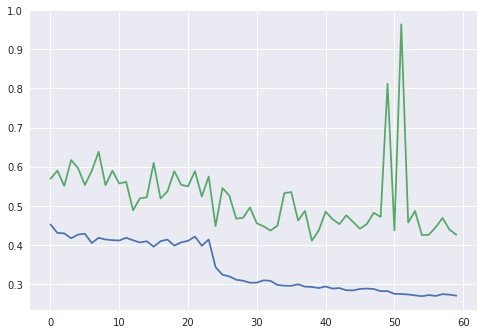

In [17]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

/home/ubuntu/data/installs/miniconda3/envs/dl-python35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


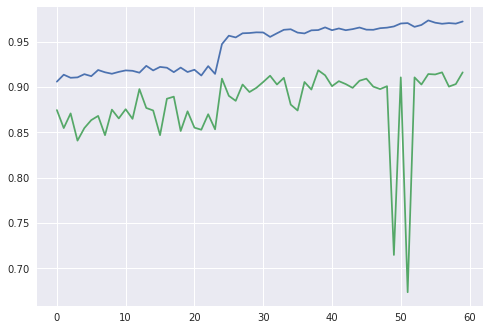

In [18]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

# TSNE

In [8]:
from keras.models import load_model

model = load_model('model/model_18.h5')

def print_model(model):
    print("[*] Sequential model created with the following layers:")
    for layer in model.layers:
        print("{:30}{} -> {}".format(layer.name, layer.input_shape, layer.output_shape)) 



In [9]:
print_model(model)

[*] Sequential model created with the following layers:
conv1d_1                      (None, 300, 13) -> (None, 300, 128)
batch_normalization_1         (None, 300, 128) -> (None, 300, 128)
leaky_re_lu_1                 (None, 300, 128) -> (None, 300, 128)
conv1d_2                      (None, 300, 128) -> (None, 300, 256)
batch_normalization_2         (None, 300, 256) -> (None, 300, 256)
leaky_re_lu_2                 (None, 300, 256) -> (None, 300, 256)
conv1d_3                      (None, 300, 256) -> (None, 300, 128)
batch_normalization_3         (None, 300, 128) -> (None, 300, 128)
leaky_re_lu_3                 (None, 300, 128) -> (None, 300, 128)
global_average_pooling1d_1    (None, 300, 128) -> (None, 128)
dense_1                       (None, 128) -> (None, 10)


In [10]:
from keras.models import Model

layer_name = 'global_average_pooling1d_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

In [18]:
intermediate_output = intermediate_layer_model.predict(train_x)
y_data = model.predict(train_x)

In [19]:
intermediate_output.shape

(6770, 128)

In [20]:
y_data_nums = [np.argmax(row) for row in y_data]

In [21]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
result = tsne_model.fit_transform(intermediate_output)

print(result)

[[ -7.44866775   6.68743613]
 [ 11.15769077   1.97122216]
 [ -7.39057814  -0.67059351]
 ..., 
 [  2.16120788   1.82891381]
 [  8.272329     1.877645  ]
 [  7.85698169  -3.96640998]]


/home/ubuntu/data/installs/miniconda3/envs/dl-python35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


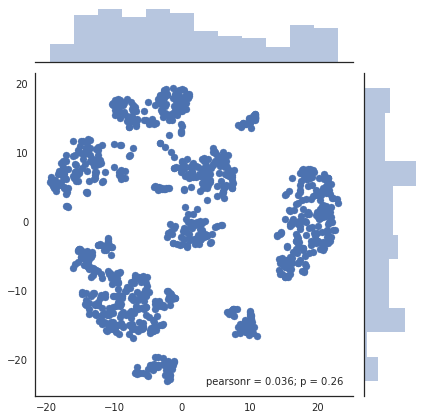

In [15]:
import seaborn as sns
sns.set(style="white", color_codes=True)
g = sns.jointplot(x=result[:,0], y=result[:,1])

/home/ubuntu/data/installs/miniconda3/envs/dl-python35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


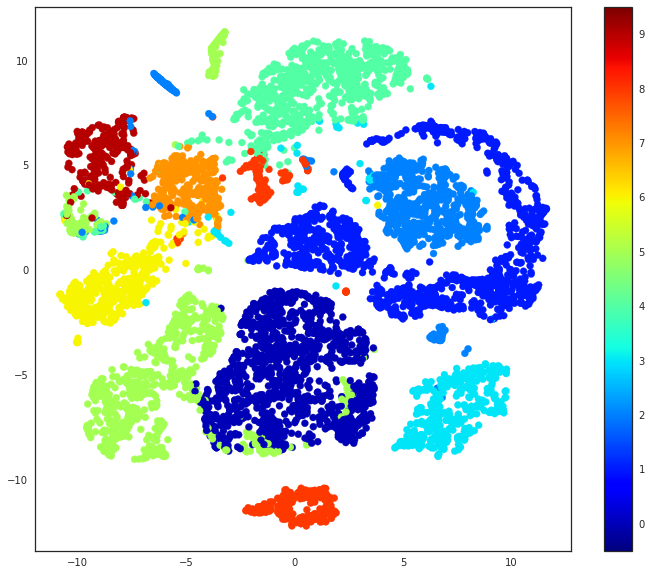

In [24]:
plt.figure(1, figsize=(12, 10))
plt.scatter(result[:,0], result[:,1], c=y_data_nums, cmap=plt.cm.get_cmap("jet"))
# plt.scatter(result[:,0], result[:,1])
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()